In [1]:
from transformers import AutoTokenizer, AutoModel, DataCollatorWithPadding
from transformers import AutoModelForSequenceClassification
from transformers import TrainingArguments
import torch
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from transformers import get_scheduler


ckpt_path = 'BM-K/KoSimCSE-roberta'
sbert_tokenizer = AutoTokenizer.from_pretrained(ckpt_path)
sbert_model = AutoModelForSequenceClassification.from_pretrained(ckpt_path, num_labels=9)

training_args = TrainingArguments("test-trainer")

torch.cuda.empty_cache()

Some weights of the model checkpoint at BM-K/KoSimCSE-roberta were not used when initializing RobertaForSequenceClassification: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at BM-K/KoSimCSE-roberta and are newly initialized: ['classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able

In [2]:
class contentDataset(Dataset):
    def __init__(self, file, tok, max_len, pad_index=None):
        super().__init__()
        self.tok =tok
        self.max_len = max_len
        self.content = pd.read_csv(file)
        self.len = self.content.shape[0]
        self.pad_index = self.tok.pad_token
    
    def add_padding_data(self, inputs, max_len):
        if len(inputs) < max_len:
            # pad = np.array([self.pad_index] * (max_len - len(inputs)))
            pad = np.array([0] * (max_len - len(inputs)))
            inputs = np.concatenate([inputs, pad])
            return inputs
        else:
            inputs = inputs[:max_len]
            return inputs
    
    def __getitem__(self,idx):
        instance = self.content.iloc[idx]
        # text = "[CLS]" + instance['content'] + "[SEP]"
        text = instance['text']
        input_ids = self.tok.encode(text)
        
        input_ids = self.add_padding_data(input_ids, max_len=self.max_len)
        label_ids = instance['label']
        # encoder_attention_mask = input_ids.ne(0).float()
        return {"encoder_input_ids" : np.array(input_ids, dtype=np.int_),
                "label" : np.array(label_ids,dtype=np.int_)}
        
    def __len__(self):
        return self.len

In [3]:
dataset = pd.read_csv('/home/keonwoo/anaconda3/envs/bgmRS/data/labeled_data_0706.csv')
dataset.drop(['Unnamed: 0'],axis=1,inplace=True)

dataset['label'] = pd.factorize(dataset['label'])[0]
# dataset.columns = ['label','text']
dataset = dataset.sample(frac=1).reset_index(drop=True)


train_num = int(len(dataset)*0.9)
trainset = dataset.iloc[:train_num]
validset = dataset.iloc[train_num:]

trainset.to_csv('/home/keonwoo/anaconda3/envs/bgmRS/data/trainset.csv')
validset.to_csv('/home/keonwoo/anaconda3/envs/bgmRS/data/validset.csv')

train_setup = contentDataset(file = "/home/keonwoo/anaconda3/envs/bgmRS/data/trainset.csv",tok = sbert_tokenizer, max_len = 128)
valid_setup = contentDataset(file = "/home/keonwoo/anaconda3/envs/bgmRS/data/validset.csv",tok = sbert_tokenizer, max_len = 128)


tarin_dataloader = DataLoader(train_setup, batch_size=256, shuffle=True)
valid_dataloader = DataLoader(valid_setup, batch_size=256, shuffle=False)

optimizer = AdamW(sbert_model.parameters(), lr=5e-5)


num_epochs = 5
num_training_steps = num_epochs * len(tarin_dataloader)
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

In [4]:
from torch.nn.parallel import DistributedDataParallel

n_gpus = torch.cuda.device_count()


device = torch.device("cuda:1") if torch.cuda.is_available() else torch.device("cpu")
sbert_model.to(device)

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(32000, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerN

In [5]:
from tqdm.auto import tqdm

progress_bar = tqdm(range(num_training_steps))
loss_list = []

sbert_model.train()
for epoch in range(num_epochs):
    for batch in tarin_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        encoder_attention_mask = batch["encoder_input_ids"].ne(0).float().to(device)
        outputs = sbert_model(batch['encoder_input_ids'], attention_mask=encoder_attention_mask, labels=batch['label'])
        loss = outputs.loss
        loss_list.append(loss.item())
        
        loss.backward()
        
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

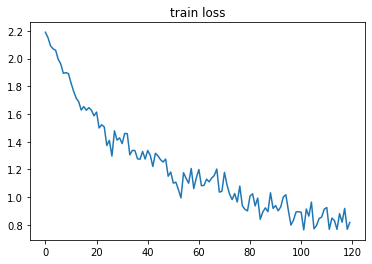

In [6]:
from matplotlib import pyplot as plt

plt.plot(loss_list)
plt.title('train loss')
plt.show()

In [7]:
import os
# os.makedirs("/home/keonwoo/anaconda3/envs/bgmRS/ckpt/sbert_snu")

sbert_model.save_pretrained("/home/keonwoo/anaconda3/envs/bgmRS/ckpt/simcse_0707")

In [10]:
device = torch.device("cuda:2") if torch.cuda.is_available() else torch.device("cpu")

model = AutoModelForSequenceClassification.from_pretrained("/home/keonwoo/anaconda3/envs/bgmRS/ckpt/simcse_0707", num_labels=9)
model.to(device)

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(32000, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerN

In [11]:
from tqdm.auto import tqdm
from datasets import load_metric

pred = []
ref = []

model.eval()
for batch in valid_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    encoder_attention_mask = batch["encoder_input_ids"].ne(0).float().to(device)
    with torch.no_grad():
        outputs = model(batch['encoder_input_ids'], attention_mask=encoder_attention_mask, labels=batch['label'])
        
    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    pred.append(predictions)
    ref.append(batch['label'])

pred = torch.cat(pred, 0)
ref = torch.cat(ref, 0)

In [12]:
acc = load_metric("accuracy")
recall = load_metric("recall")
f1 = load_metric("f1")
prec = load_metric("precision")


acc.compute(predictions=pred, references=ref)

{'accuracy': 0.562874251497006}

In [13]:
prec.compute(predictions=pred, references=ref, average="weighted")

{'precision': 0.5622220179433336}

In [14]:
recall.compute(predictions=pred, references=ref, average="weighted")

{'recall': 0.562874251497006}

In [15]:
f1.compute(predictions=pred, references=ref, average="weighted")

{'f1': 0.5563569609597907}